# Using the LSST DM Stack in Python

This tutorial focuses on using the DM stack in Python.  Some of the things we'll be doing are more commonly done on the command-line, via executable scripts the stack also provides.  A complete tutorial for the command-line functionality can be found in [DM Tech Note 23](https://dmtn-023.lsst.io/).

More notebook examples can be found here: https://github.com/RobertLuptonTheGood/notebooks/tree/master/Demos

## Data Repository Setup

Instead of operating directly on files and directories, we interact with on-disk data products via an abstraction layer called the *data butler*.  The butler operates on *data repositories*, and our first task is to set up a repository with some raw data, master calibration files, and an external reference catalog.  All of these are from a self-contained test dataset we call [ci_hsc](https://github.com/lsst/ci_hsc).  I won't go into the details of how to build master calibration files or reference catalogs here.

We'll do these first few steps effectively on the command-line, and use a Jupyter trick to do that here:

In [ ]:
%%script bash
export CI_HSC_DIR=/mnt/lsst/datasets/ci_hsc/
mkdir DATA
echo "lsst.obs.hsc.HscMapper" > DATA/_mapper
ingestImages.py DATA $CI_HSC_DIR/raw/*.fits --mode=link
cd DATA
ln -s $CI_HSC_DIR/CALIB .
mkdir ref_cats
cd ref_cats
ln -s $CI_HSC_DIR/ps1_pv3_3pi_20170110 .

## Instrument Signature Removal and Command-Line Tasks

Before we can start doing *interesting* things, we need some minimally processed images (i.e. flat-fielded, bias-corrected, etc).  Because the HSC team has spent a lot of time characterizing the instrument, we really want to run this step with the default configuration they've provided.  That's actually easier to do from the command-line (see [DMTN-23](https://dmtn-023.lsst.io/)), but it's quite possible to do it from Python.

ISR is implemented as a subclass of `lsst.pipe.base.Task`.  Nearly all of our high-level algorithms are implemented as `Task`s, which are essentially just callable objects that can be composed (a high-level `Task` can hold one or more lower-level "subtasks", to which it can delegate work) and configured (every task takes an instance of a configuration class that controls what it does in detail).  ISR is actually a `CmdLineTask`, a special kind of task that can be run from the command-line and use the data butler for all of its inputs and outputs (regular `Task`s generally do not use the butler directly).  Unlike virtually every other algorithm, there is a different ISR `Task` for each major camera (though there's also a simple default one), reflecting the specialized processing that's needed at this level.

Here's how we configure and instantiate the HSC ISR `Task`.

In [5]:
import os
from lsst.utils import getPackageDir
from lsst.obs.subaru.isr import SubaruIsrTask

In [6]:
isrConfig = SubaruIsrTask.ConfigClass()
isrConfig.load(os.path.join(getPackageDir("obs_subaru"), "config", "hsc", "isr.py"))
isrConfig.doWrite = True  # usually we don't save the image until we've subtracted the background (not part of ISR)
isrTask = SubaruIsrTask(config=isrConfig)

To run ISR, we need to create a `Butler` instance and a data repository for it to work with.  Data repositories can be *chained*: each repository can have a *parent* repository (or in rare cases, multiple parents) from which data products can be retrieved when they aren't present in the repository itself.

For most processing, we use a Butler configured with both an input repository and and output repository, which automatically chains the input to the output.

In [7]:
from lsst.daf.persistence import Butler

In [8]:
butler = Butler(inputs="DATA", outputs="DATA/rerun/isr")

Command-line tasks like `SubaruIsrTask` operate on `DataRef`s, which combine a `Butler` instance, a dataset type name ("raw", for the raw data that ISR uses as input), and a data ID: a set of key-value pairs that describe the data to process.  

In [9]:
dataRef = butler.dataRef("raw", visit=903334, ccd=16)
dataId = dataRef.dataId

In [10]:
dataId

{'ccd': 16,
 'dateObs': '2013-06-17',
 'expTime': 30.0,
 'field': 'STRIPE82L',
 'filter': 'HSC-R',
 'pointing': 533,
 'taiObs': '2013-06-17',
 'visit': 903334}

We can now run `SubaruIsrTask` (on the first `DataRef`), and extract the `lsst.afw.image.Exposure` object that represents the detrended image:

In [ ]:
isrResult = isrTask.runDataRef(dataRef)
exposure = isrResult.exposure

## Image, Boxes, and (Crude) Image Display

A full 2k x 4k HSC CCD is a pretty big image to display when you don't have specialized display code.  The DM stack does have specialized display code, but it either requires DS9 (which requires some ssh tunnels to use with data living on a server) or a Firefly server installation. For this tutorial, we'll just throw together a naive matplotlib display function, and create a view to a subimage that we'll display instead of the full image.

This section features a few of our most important class objects:

- `lsst.afw.image.Exposure` is an image object that actually holds three image planes: the science image (`Exposure.image`), an image of variance in every pixel (`Exposure.variance`), an integer bit mask (`Exposure.mask`).  It also holds a lot of more complex objects that characterize the image, such as a point-spread function (`lsst.afw.detection.Psf`) and world-coordinate system (`lsst.afw.image.Wcs`).  Most of these objects aren't filled in yet, because all we've run so far is ISR.  It doesn't generally make sense to perform mathematical operations (i.e. addition) on `Exposure`s, because those operations aren't always well-defined on the more complex objects.  You can get a `MaskedImage` object with the same image, mask, and variance planes that does support mathematical operations but doesn't contain `Psf`s and `Wcs`s (etc) with `Exposure.maskedImage`.

- The `Exposure.image` and `Exposure.variance` properties return `lsst.afw.image.Image` objects.  These have a `.array` property that returns a `numpy.ndarray` view to the `Image`'s pixels.  Conceptually, you should think of an `Image` as just a `numpy.ndarray` with a possibly nonzero origin.

- The `Exposure.mask` property returns a `lsst.afw.image.Mask` object, which behaves like an `Image` with a dictionary-like object that relates string labels to bit numbers.

- All of these image-like objects have a `getBBox()` method, which returns a `lsst.afw.geom.Box2I`.  The minimum and maximum points of a `Box2I` are specified in integers that correspond to the *centers* of the lower-left and upper-right pixels in the box, but the box conceptually contains the entirety of those pixels.  To get a box with a floating-point representation of the same boundary for the `extent` argument to `imshow` below, we construct a `Box2D` from the `Box2I`.

- `Point2I` and `Extent2I` are used to represent absolute positions and offsets between positions as integers (respectively).  These have floating-point counterparts `Point2D` and `Extent2D`.

In [11]:
from lsst.afw.geom import Box2D, Box2I, Point2I, Extent2I
from lsst.afw.image import Exposure

In [12]:
# Previous Butler can't read from its output repository, so we may a new one with the old output as the input.
butler = Butler(inputs="DATA/rerun/isr")

In [13]:
# Execute this cell (and the one below) to re-load the post-ISR Exposure from disk
exposure = butler.get("postISRCCD", dataId)

In [14]:
bbox = exposure.getBBox()
bbox.grow(-bbox.getDimensions()//3)  # box containing the central third (in each dimension)
bbox.grow(-Extent2I(0, 400))  # make it a bit smaller in x
# exposure[bbox] would also work here because exposure.getXY0() == (0, 0),
# but it's dangerous in general because it ignores that origin.
sub = Exposure(exposure, bbox=bbox, dtype=exposure.dtype, deep=False)

In [15]:
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (8, 6)
matplotlib.rcParams["font.size"] = 12

In [16]:
def display(image, mask=None, colors=None, alpha=0.40, **kwds):
    box = Box2D(image.getBBox())
    extent = (box.getMinX(), box.getMaxX(), box.getMinY(), box.getMaxY())
    kwds.setdefault("extent", extent)
    kwds.setdefault("origin", "lower")
    kwds.setdefault("interpolation", "nearest")
    matplotlib.pyplot.imshow(image.array, **kwds)
    kwds.pop("vmin", None)
    kwds.pop("vmax", None)
    kwds.pop("norm", None)
    kwds.pop("cmap", None)
    if mask is not None:
        for plane, color in colors.items():
            array = np.zeros(mask.array.shape + (4,), dtype=float)
            rgba = np.array(matplotlib.colors.hex2color(matplotlib.colors.cnames[color]) + (alpha, ),
                            dtype=float)
            np.multiply.outer((mask.array & mask.getPlaneBitMask(plane)).astype(bool), rgba, out=array)
            matplotlib.pyplot.imshow(array, **kwds)

And now here's the (cutout) of the detrended image.  I've cheated in setting the scale by looking at the background level in advance.

In [ ]:
display(sub.image, vmin=175, vmax=300, cmap=matplotlib.cm.gray)

## Background Subtraction and Task Configuration

The next step we usually take is to estimate and subtract the background, using `lsst.meas.algorithms.SubtractBackgroundTask`.  This is a regular `Task`, not a `CmdLineTask`, and hence we'll just pass it our `Exposure` object (it operates in-place) instead of a `Butler`.

In [17]:
from lsst.meas.algorithms import SubtractBackgroundTask

In [18]:
bkgConfig = SubtractBackgroundTask.ConfigClass()

In [ ]:
# Execute this cell to get fun & terrible results!
bkgConfig.useApprox = False
bkgConfig.binSize = 20

The pattern for configuration here is the same as it was for `SubaruIsrTask`, but here we're setting values directly instead of loading a configuration file from the `obs_subaru` camera-specialization package.  The `config` object here is an instance of a class that inherits from `lsst.pex.config.Config` that contains a set of `lsst.pex.config.Field` objects that define the options that can be modified.  Each `Field` behaves more or less like a Python `property`, and you can get information on all of the fields in a config object by either using `help`:

In [ ]:
help(bkgConfig)

In [ ]:
SubtractBackgroundTask.ConfigClass.algorithm?

In [19]:
bkgTask = SubtractBackgroundTask(config=bkgConfig)

In [20]:
bkgResult = bkgTask.run(exposure)

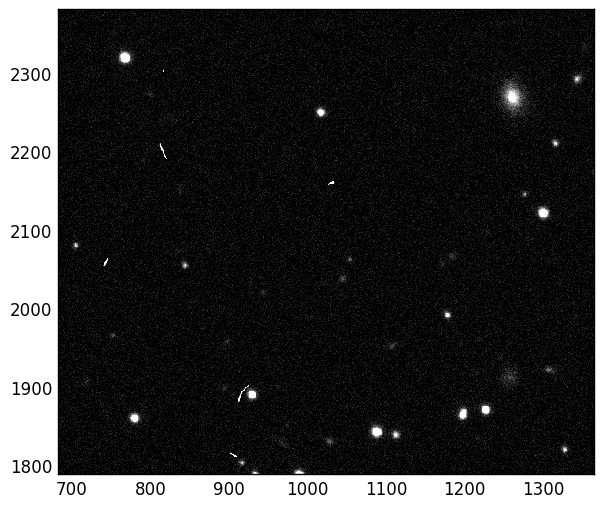

In [21]:
display(sub.image, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)

## Installing an Initial-Guess PSF

Most later processing steps require a PSF model, which is represented by a `Psf` object that's attached to the `Exposure`.  For now, we'll just make a Gaussian PSF with some guess at the seeing.

In [22]:
from lsst.meas.algorithms import SingleGaussianPsf

In [23]:
FWHM_TO_SIGMA = 1.0/(2*np.sqrt(2*np.log(2)))
PIXEL_SCALE = 0.168  # arcsec/pixel
SEEING = 0.7         # FWHM in arcsec
sigma = FWHM_TO_SIGMA*SEEING/PIXEL_SCALE
width = int(sigma*3)*2 + 1
psf = SingleGaussianPsf(width, width, sigma=sigma)
exposure.setPsf(psf)

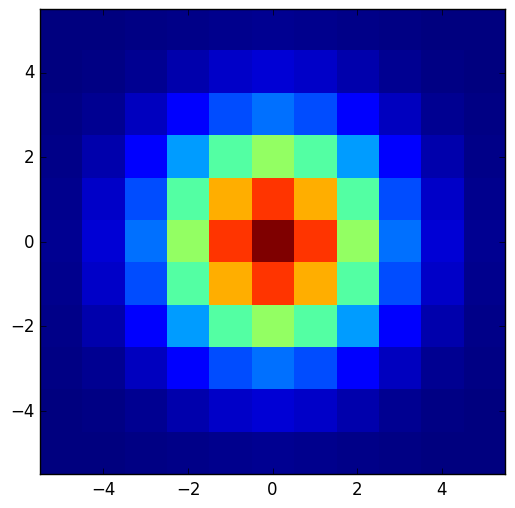

In [24]:
from lsst.afw.geom import Point2D
display(psf.computeKernelImage(Point2D(60.5, 7.2)))

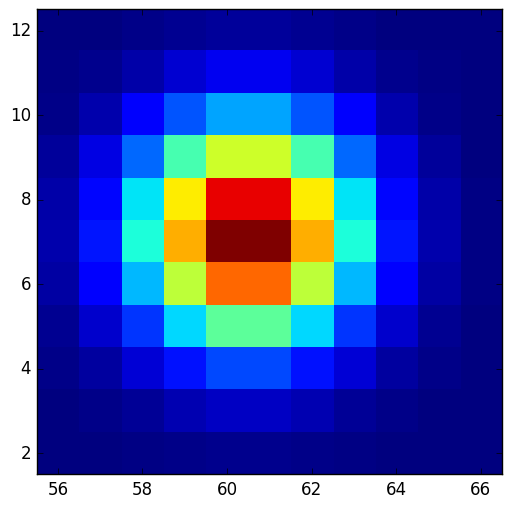

In [25]:
display(psf.computeImage(Point2D(60.5, 7.2)))

## Removing Cosmic Rays

Cosmic rays are detected and interpolated by `RepairTask`, which also sets mask planes to indicate where the cosmic rays were ("CR") and which pixels were interpolated ("INTERP"; this may happen due to saturation or bad pixels as well).  Because we're just using the default configuration, we can skip creating a config object and just construct the `Task` with no arguments.

In [26]:
from lsst.pipe.tasks.repair import RepairTask

In [27]:
repairTask = RepairTask()

In [28]:
repairTask.run(exposure)

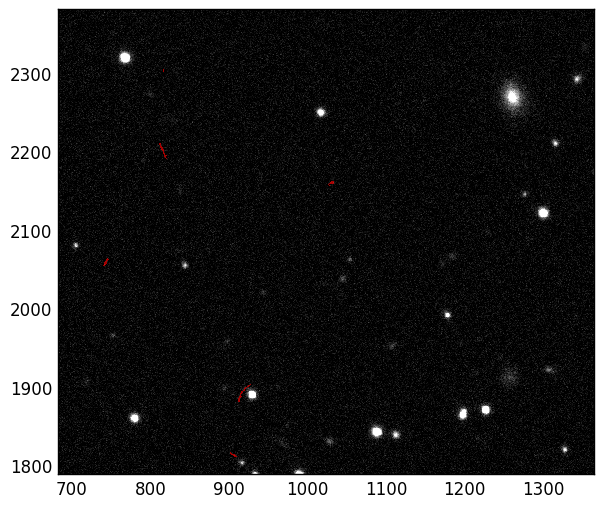

In [29]:
display(sub.image, mask=sub.mask, colors={"CR": "red"},
        vmin=-0.5, vmax=100, alpha=0.8, cmap=matplotlib.cm.gray)

## Detecting Sources

Unlike the other `Task`s we've dealt with so far, `SourceDetectionTask` creates a `SourceCatalog` in addition to updating the image (all it does to the image is add a "DETECTED" mask plane).  All `Task`s that work with catalogs need to be initialized with a `lsst.afw.table.Schema` object, to which the `Task` will add the fields necessary to store its outputs.  A `SourceCatalog`'s `Schema` cannot be modified after the `SourceCatalog` has been constructed, which means it's necessary to construct all `Schema`-using `Task`s before actually running any of them.

Each record in the catalog returned by `SourceDetectionTask` has a `Footprint` object attached to it.  A `Footprint` represents the approximate region covered by a source in a run-length encoding data structure.  It also contains a list of peaks found within that region.  The "DETECTED" mask plane is set to exactly the pixels covered by any `Footprint` in the returned catalog.

In [30]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.afw.table import SourceTable, SourceCatalog

In [41]:
schema = SourceTable.makeMinimalSchema()

In [42]:
detectTask = SourceDetectionTask(schema=schema)

In [44]:
# A SourceTable is really just a factory object for records; don't confuse it with SourceCatalog, which is
# usually what you want.  But a SourceTable *is* what SourceDetectionTask wants here.
table = SourceTable.make(schema)

In [45]:
detectResult = detectTask.run(table, exposure)

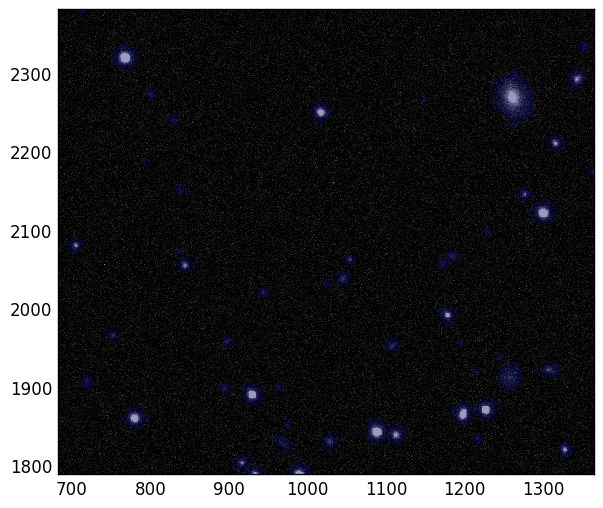

In [35]:
display(sub.image, mask=sub.mask, colors={"DETECTED": "blue"}, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)

## Deblending

Deblending attempts to separate detections with multiple peaks into separate objects.  We keep all of the original sources in the `SourceCatalog` (called `parent`s) when we deblend, but for each `parent` source that contains more than one peak, we create a new record (called a `child`) for each of those peaks.  The `Footprint`s attached to the `child` objects are instances of a subclass called `HeavyFootprint`, which include new deblended pixel values as well as the region description.  These can be used by calling `insert` to replace an `Image`'s pixels with the `HeavyFootprint`'s pixels.

**EXERCISE**: This section will not run if the cells are executed naively in order.  At some point you'll have to go re-execute one or more cells in the previous section to get the right behavior.  Which one(s)?  Why?

In [36]:
from lsst.meas.deblender import SourceDeblendTask

In [55]:
schema = SourceTable.makeMinimalSchema()

In [56]:
detectTask = SourceDetectionTask(schema=schema)

In [57]:
deblendTask = SourceDeblendTask(schema=schema)

In [58]:
table = SourceTable.make(schema)

In [59]:
detectResult = detectTask.run(table, exposure)

In [60]:
catalog = detectResult.sources

In [63]:
deblendTask.run(exposure, catalog)

To inspect some deblender outputs, we'll start by finding some parent objects that were deblended into multiple children, by looking at the `deblend_nChild` field (which was added to the `Schema` when we constructed the `SourceDeblendTask`, and populated when we called `run`).

In [64]:
# Find some blended sources inside the subimage:
blendParents = []
for record in catalog:
    if record.get("deblend_nChild") > 0 and bbox.contains(record.getFootprint().getBBox()):
        blendParents.append(record)
# Sort by peak brightness so we can look at something with decent S/N
blendParents.sort(key=lambda r: -r.getFootprint().getPeaks()[0].getPeakValue())

In [65]:
from lsst.afw.image import Image

The image of the parent object is just the original image, but we'll cut out just the region inside its `Footprint`:

In [66]:
blendParentImage = Image(exposure.image, bbox=blendParents[0].getFootprint().getBBox(),
                         deep=True, dtype=np.float32)

Now we'll insert the deblended child pixels into blank images of the same size:

In [67]:
blendChildImages = []
for blendChild in catalog.getChildren(blendParents[0].getId()):
    image = Image(blendParentImage.getBBox(), dtype=np.float32)
    blendChild.getFootprint().insert(image)
    blendChildImages.append(image)

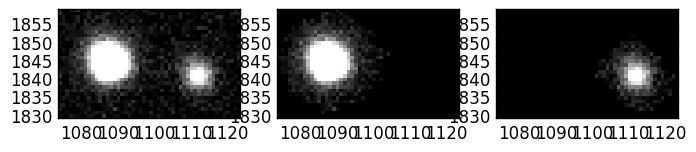

In [68]:
nSubPlots = len(blendChildImages) + 1
nCols = 3
nRows = nSubPlots//nCols + 1
matplotlib.pyplot.subplot(nRows, nCols, 1)
display(blendParentImage, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)
for n, image in enumerate(blendChildImages):
    matplotlib.pyplot.subplot(nRows, nCols, n + 2)
    display(image, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)

## Measurement

`SingleFrameMeasurementTask` is typically responsible for adding most fields to a `SourceCatalog`.  It runs a series of plugins that make different measurements (you can configure them with the `.plugins` dictionary-like field on its config object, and control which are run with `.names`).  If the deblender has been run first, it will measure child objects using their deblended pixels.

**EXERCISE**: Like the Deblending section, you'll have to re-execute some previous cells somewhere in this section to get the right behavior.

In [69]:
from lsst.meas.base import SingleFrameMeasurementTask

In [86]:
schema = SourceTable.makeMinimalSchema()
detectTask = SourceDetectionTask(schema=schema)
deblendTask = SourceDeblendTask(schema=schema)

In [87]:
measureConfig = SingleFrameMeasurementTask.ConfigClass()

In [96]:
# What measurements are configured to run
print(measureConfig.plugins.names)

In [89]:
# Import an extension module that adds a new measurement
import lsst.meas.extensions.photometryKron

In [95]:
# What measurements *could* be configured to run
print(list(measureConfig.plugins.keys()))

In [91]:
# Configure the new measurement to run
measureConfig.plugins.names.add("ext_photometryKron_KronFlux")

In [92]:
measureTask = SingleFrameMeasurementTask(schema=schema, config=measureConfig)

In [93]:
table = SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
deblendTask.run(exposure, catalog)

In [94]:
measureTask.run(catalog, exposure)

In [74]:
from lsst.afw.geom.ellipses import Axes

We'll show some of the results of measurement by overlaying the measured ellipses on the image.

The shapes and centroids we use here (by calling `record.getX()`, `record.getY()`, `record.getShape()`) are aliases  (called "slots") to fields with longer names that are our recommended measurements for these quantities.  You can see the set of aliases by printing the schema (see next section).

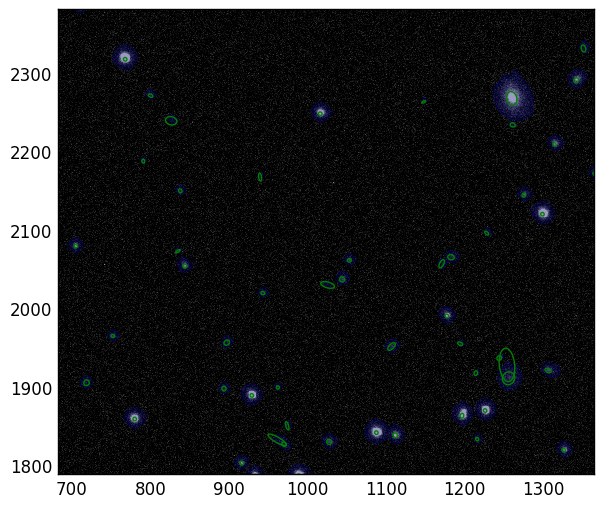

In [75]:
display(sub.image, mask=sub.mask, colors={"DETECTED": "blue"}, vmin=-0.5, vmax=100, cmap=matplotlib.cm.gray)

for record in catalog:
    if record.get("deblend_nChild") != 0:
        continue
    axes = Axes(record.getShape())   # convert to A, B, THETA parameterization
    axes.scale(2.0)  # matplotlib uses diameters, not radii
    patch = matplotlib.patches.Ellipse((record.getX(), record.getY()),
                                       axes.getA(), axes.getB(), axes.getTheta() * 180.0 / np.pi,
                                      fill=False, edgecolor="green")
    matplotlib.pyplot.gca().add_patch(patch)
matplotlib.pyplot.show()

## Working With Catalogs

Print the schema:

In [ ]:
print(catalog.getSchema())

Get arrays of columns (requires the catalog to be continguous in memory, which we can guarantee with a deep copy):

In [97]:
catalog = catalog.copy(deep=True)

In [98]:
psfFlux = catalog["base_PsfFlux_flux"]

Note that boolean values are stored in `Flag` columns, which are packed into bits.  Unlike other column types, when you get an array of a `Flag` column, you get a copy, not a view.

Use `Key` objects instead of strings to do fast repeated access to fields when iterating over records:

In [99]:
key = catalog.getSchema().find("deblend_nChild").key
deblended = [record for record in catalog if record.get(key) == 0]

You can also get `dict` version of a subset of a `Schema`, a `Catalog`, or a `Record` by calling either `extract` methods with a glob:

In [100]:
catalog[0].extract("base_PsfFlux_*")  # or regex='...'

{'base_PsfFlux_flag': True,
 'base_PsfFlux_flag_badCentroid': True,
 'base_PsfFlux_flag_badCentroid_almostNoSecondDerivative': False,
 'base_PsfFlux_flag_badCentroid_edge': True,
 'base_PsfFlux_flag_badCentroid_noSecondDerivative': False,
 'base_PsfFlux_flag_badCentroid_notAtMaximum': False,
 'base_PsfFlux_flag_badCentroid_resetToPeak': False,
 'base_PsfFlux_flag_edge': False,
 'base_PsfFlux_flag_noGoodPixels': False,
 'base_PsfFlux_flux': 2648.8588674306493,
 'base_PsfFlux_fluxSigma': 50.459404351215504}

For `Record`s, the dict values are just the values of the fields, and for `Catalogs`, they're `numpy.ndarray` columns.  For `Schema`s they're `SchemaItem`s, which behave liked a named tuple containing a `Key` and a `Field`, which contains more descriptive information.

Get an Astropy view of the catalog (from which you can make a Pandas view):

In [101]:
table = catalog.asAstropy()

You can find some reference documentation for the catalog library [here](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/afw_table.html).

# Exercises

0. Make a scatter plot of Kron Flux vs. Psf Flux.

1. Write a single function that performs all of the above steps on a post-ISR `Exposure` object, modifying the `Exposure` in-place and returning a new `SourceCatalog` with a complete set of measurements.

2. Add PSF modeling to the end of that function, delegating most of the work to `lsst.pipe.tasks.MeasurePsfTask`.  You may want to use a higher threshold (e.g. 50-sigma) for detection, since PSF modeling should only use bright stars.

3. Make images of the PSF stars, the PSF model at the position of those stars, and the difference between them.

4. Add another detect-deblend-measure sequence after PSF modeling at a deeper threshold.

5. Rewrite the function as a class that constructs all of the `Task`s that it use in `__init__` and processes a single `Exposure` with you call its `run` method.  Make sure it will behave properly if `run` is called multiple times wiht different `Exposure` objects.


- 